In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import phate
import scprep
import mellon
import palantir
# import altair as alt

In [2]:
adata = sc.read_h5ad('/home/xiyuanz/TBI_Tcells/data/TBI.h5ad')
target_cell_type= 'Monocyte_Classical'
target = adata[adata.obs['ReDefined_CellType'] == target_cell_type].copy()

In [3]:
import matplotlib
%matplotlib inline

# Customize matplotlib settings
matplotlib.rcParams["figure.dpi"] = 100  # Adjusts the resolution of the figure.
matplotlib.rcParams["image.cmap"] = "Spectral_r"  # Sets the default colormap.
matplotlib.rcParams["figure.figsize"] = [6, 6]  # Defines the default figure size.

# Disabling the axes for a more minimalistic plot look:
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.spines.left"] = False
matplotlib.rcParams["axes.spines.right"] = False

In [4]:
test0 = adata[adata.obs['time'].isin(['day0','day1'])]

In [5]:
test0
sc.pp.normalize_total(test0, target_sum=1e4)
sc.pp.log1p(test0)

/home/xiyuanz/miniconda3/envs/cellchat/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
sc.pp.highly_variable_genes(test0,n_top_genes =10000)
test0= test0[:,test0.var['highly_variable']]

In [7]:
test0

View of AnnData object with n_obs × n_vars = 58612 × 10000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'percent.redcell', 'Sample', 'doublet_scores', 'predicted_doublets', 'Dataset', 'Cluster', 'mtrain_index', 'color', 'ReDefined_CellType', 'OriCluster', 'condition', 'time', 'patient'
    var: 'gene_ids', 'feature_types', 'genome', 'RefGeneList', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Celltype_OrderNumber', 'Celltype_Score_RefCellType', 'ReDefined_CellType_colors', 'mclasses_names', 'mwanted_order', 'pca', 'refcolor_dict', 'train_set_gene', 'log1p', 'hvg'
    obsm: 'CelltypeScoreCoordinates', 'Celltype_Score', 'Celltype_ScoreAll', 'NormalizedMatrix', 'PCAraw0', 'X_pca', 'X_umap', 'test_set_values'

In [8]:
sc.pp.neighbors(test0, n_neighbors=30, use_rep='X_pca', n_pcs=18) 
sc.tl.umap(test0)

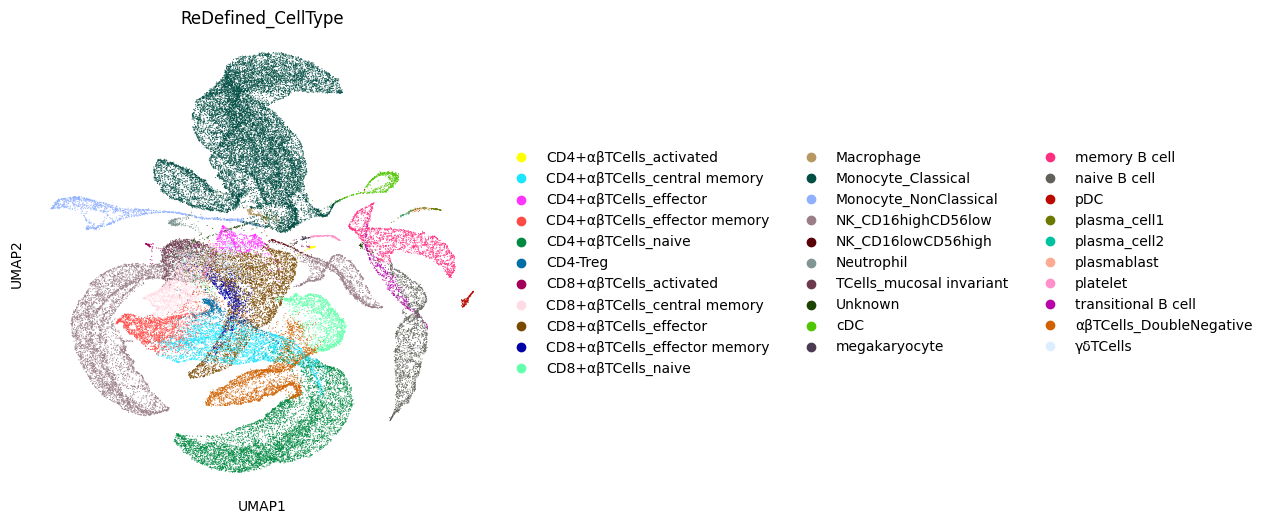

In [9]:
sc.pl.umap(test0,color=['ReDefined_CellType'])

In [61]:
# run diffusion map on integrated data
dm_res = palantir.utils.run_diffusion_maps(test0, pca_key="X_pca", n_components=20)

In [10]:
healthy = test0[test0.obs['time'] == 'day0'].copy()
mild = test0[test0.obs['condition'] == 'Mild'].copy()
severe = test0[test0.obs['condition'] == 'Severe'].copy()

### Train the model and make prediction seperately

In [13]:
model = mellon.DensityEstimator()
log_density = model.fit_predict(healthy.obsm["DM_EigenVectors"])

predictor = model.predict

healthy.obs["mellon_log_density"] = log_density
healthy.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

[2024-07-12 14:55:11,071] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (23,945) and rank = 1.0.
[2024-07-12 14:55:11,072] [INFO    ] Computing nearest neighbor distances.
[2024-07-12 14:55:15,447] [INFO    ] Using embedding dimensionality d=20. Use d_method="fractal" to enable effective density normalization.
[2024-07-12 14:55:15,723] [INFO    ] Using covariance function Matern52(ls=0.0027361977754935393).
[2024-07-12 14:55:15,727] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-07-12 14:55:45,978] [INFO    ] Using rank 5,000 covariance representation.
[2024-07-12 14:55:54,124] [INFO    ] Running inference using L-BFGS-B.
[2024-07-12 14:56:36,253] [INFO    ] Computing predictive function.


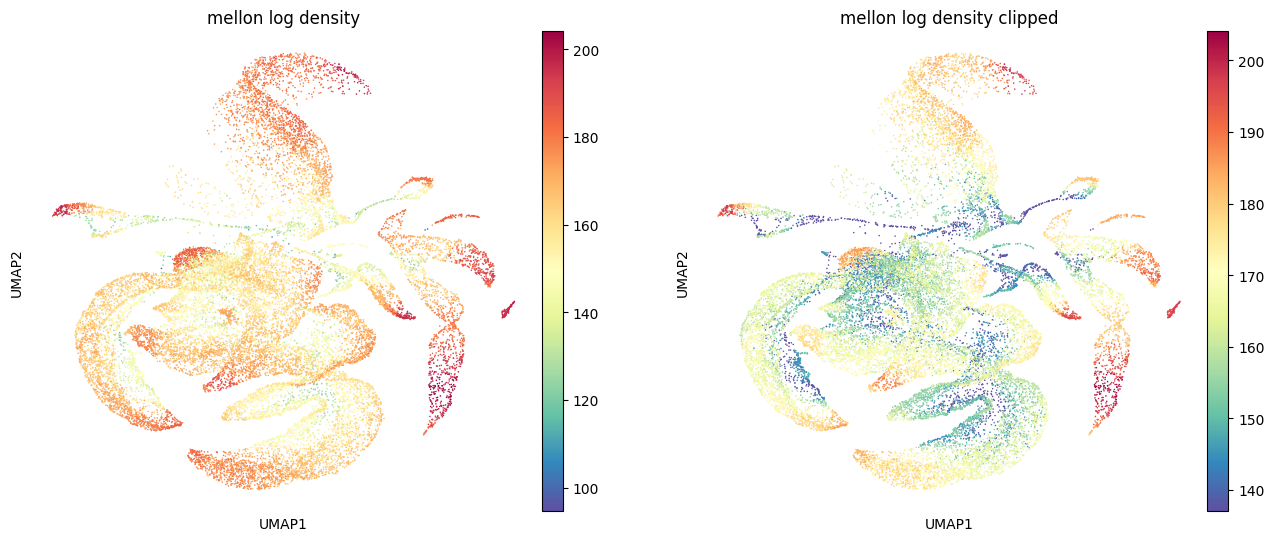

In [14]:
#base line
sc.pl.scatter(
    healthy, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)

In [15]:
dm_res = palantir.utils.run_diffusion_maps(severe, pca_key="X_pca", n_components=20)

In [16]:
model = mellon.DensityEstimator()
log_density = model.fit_predict(severe.obsm["DM_EigenVectors"])

predictor = model.predict

severe.obs["mellon_log_density"] = log_density
severe.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

[2024-07-12 14:56:43,078] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (14,198) and rank = 1.0.
[2024-07-12 14:56:43,080] [INFO    ] Computing nearest neighbor distances.
[2024-07-12 14:56:45,770] [INFO    ] Using embedding dimensionality d=20. Use d_method="fractal" to enable effective density normalization.
[2024-07-12 14:56:45,929] [INFO    ] Using covariance function Matern52(ls=0.0054001415493636195).
[2024-07-12 14:56:45,933] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-07-12 14:57:05,476] [INFO    ] Using rank 5,000 covariance representation.
[2024-07-12 14:57:10,915] [INFO    ] Running inference using L-BFGS-B.
[2024-07-12 14:57:35,880] [INFO    ] Computing predictive function.


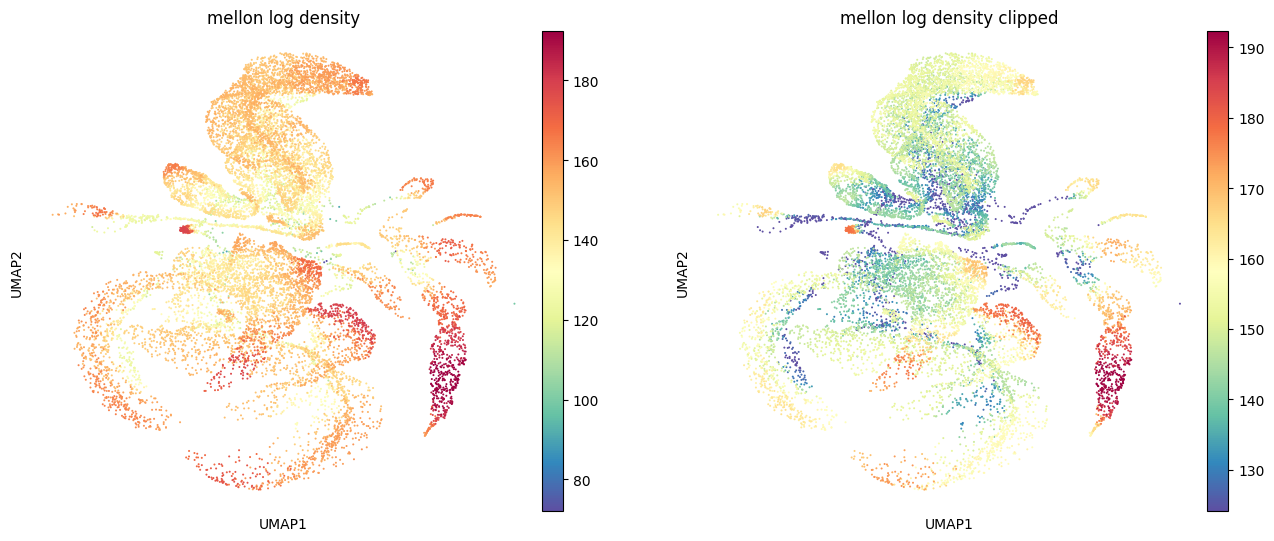

In [18]:
#base line
sc.pl.scatter(
    severe, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)

In [19]:
dm_res = palantir.utils.run_diffusion_maps(mild, pca_key="X_pca", n_components=20)

In [20]:
model = mellon.DensityEstimator()
log_density = model.fit_predict(mild.obsm["DM_EigenVectors"])

predictor = model.predict

mild.obs["mellon_log_density"] = log_density
mild.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

[2024-07-12 14:59:16,995] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (20,469) and rank = 1.0.
[2024-07-12 14:59:16,997] [INFO    ] Computing nearest neighbor distances.
[2024-07-12 14:59:22,028] [INFO    ] Using embedding dimensionality d=20. Use d_method="fractal" to enable effective density normalization.
[2024-07-12 14:59:22,194] [INFO    ] Using covariance function Matern52(ls=0.0033326988246118474).
[2024-07-12 14:59:22,198] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-07-12 14:59:47,379] [INFO    ] Using rank 5,000 covariance representation.
[2024-07-12 14:59:54,406] [INFO    ] Running inference using L-BFGS-B.
[2024-07-12 15:00:33,749] [INFO    ] Computing predictive function.


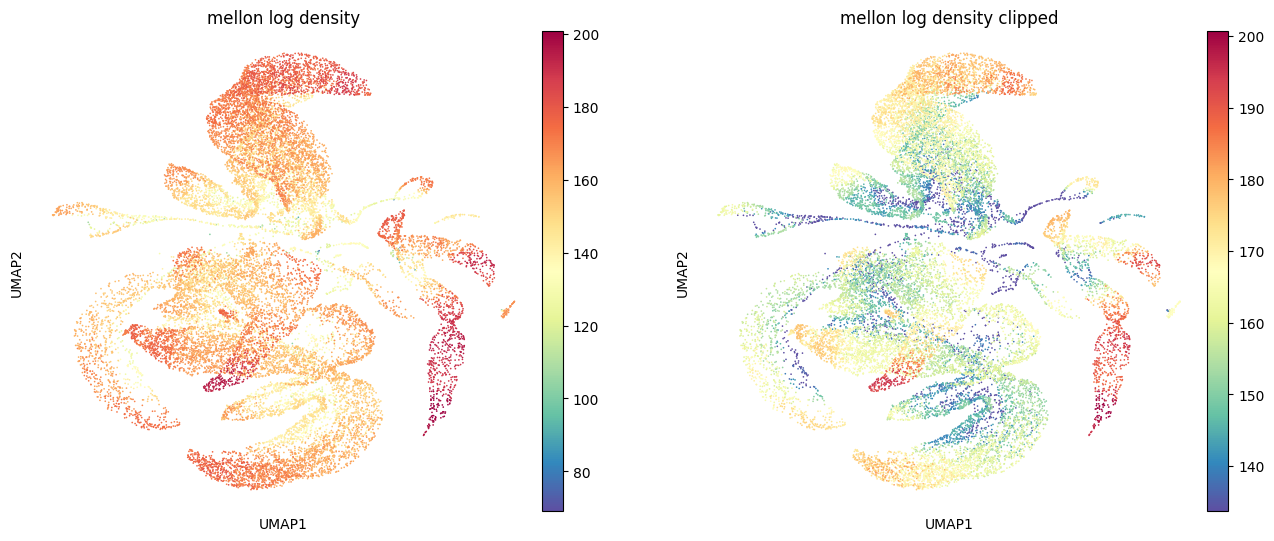

In [21]:
#base line
sc.pl.scatter(
    mild, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)

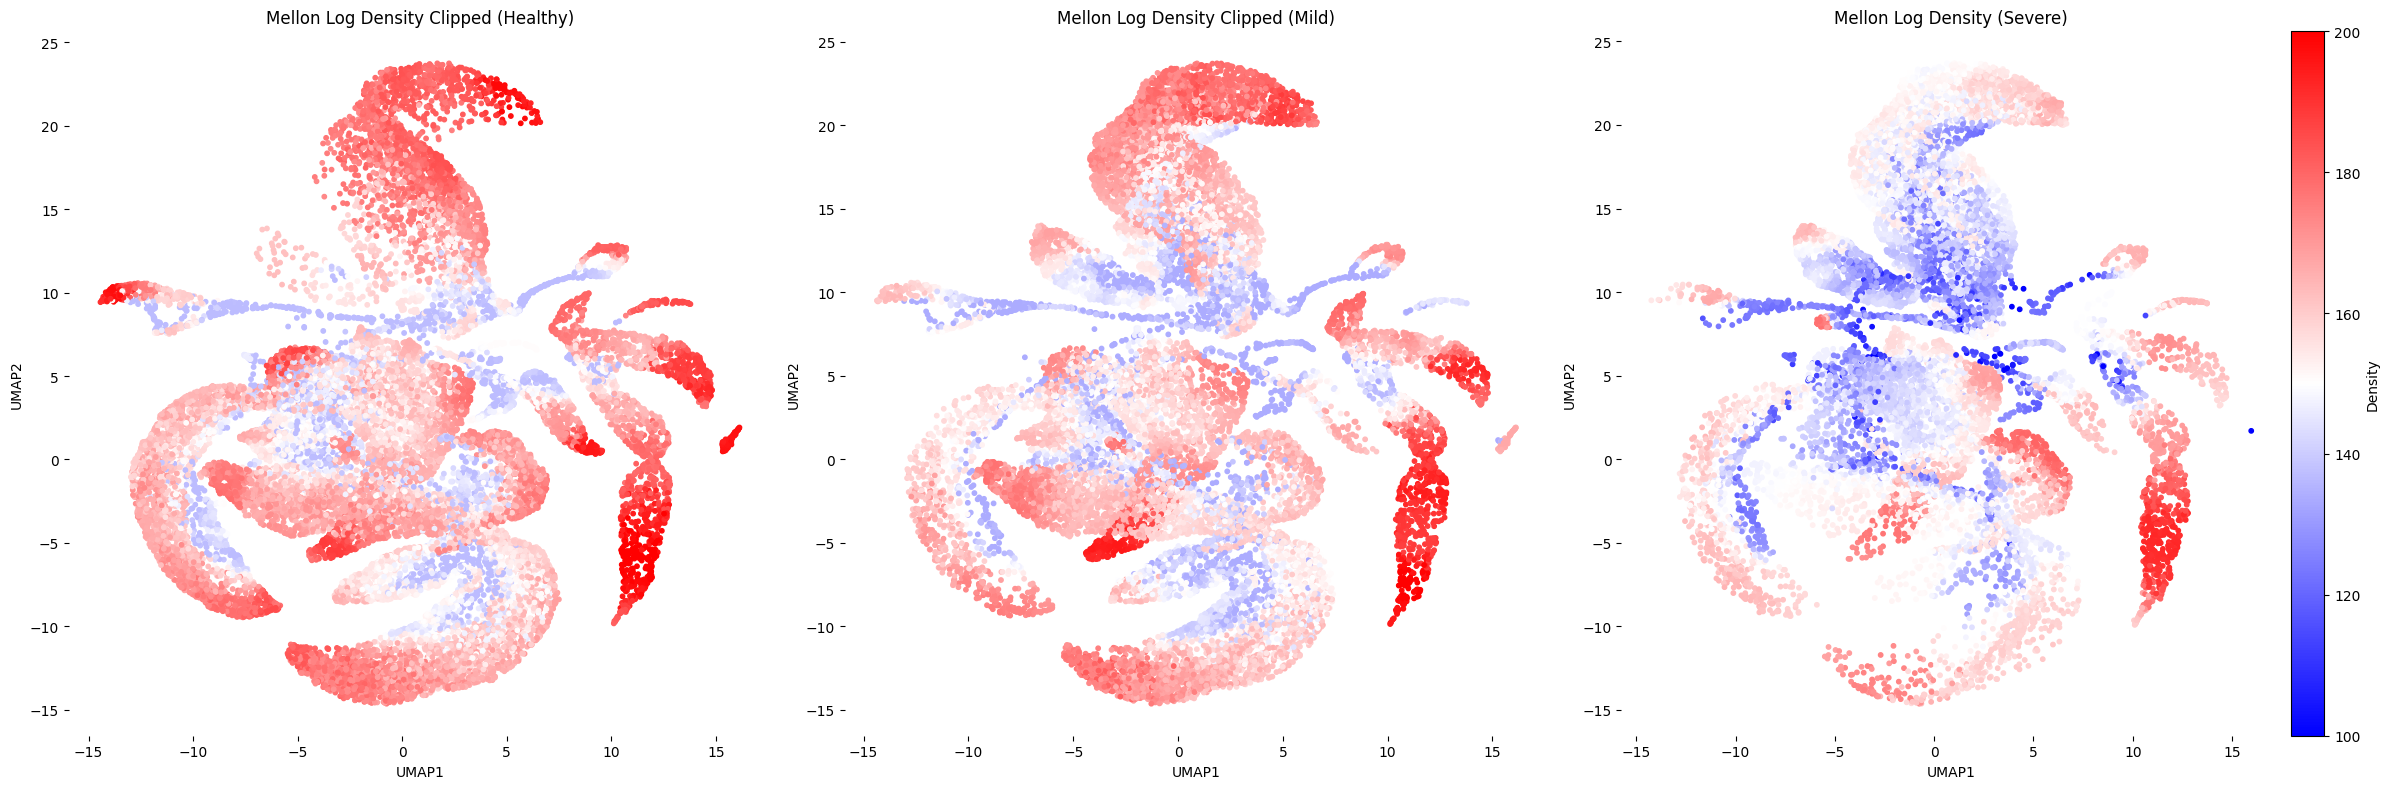

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

umap_healthy = healthy.obsm['X_umap']
umap_mild = mild.obsm['X_umap']
umap_severe = severe.obsm['X_umap']

color_healthy = healthy.obs['mellon_log_density_clipped']
color_mild = mild.obs['mellon_log_density_clipped']
color_severe = severe.obs['mellon_log_density']

common_vmin = 100
common_vmax = 200
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
dot_size = 10

sc1 = axes[0].scatter(umap_healthy[:, 0], umap_healthy[:, 1], c=color_healthy, vmin=common_vmin, vmax=common_vmax, cmap='bwr', s=dot_size)
axes[0].set_title("Mellon Log Density Clipped (Healthy)")
axes[0].set_xlabel('UMAP1')
axes[0].set_ylabel('UMAP2')

sc2 = axes[1].scatter(umap_mild[:, 0], umap_mild[:, 1], c=color_mild, vmin=common_vmin, vmax=common_vmax, cmap='bwr', s=dot_size)
axes[1].set_title("Mellon Log Density Clipped (Mild)")
axes[1].set_xlabel('UMAP1')
axes[1].set_ylabel('UMAP2')

sc3 = axes[2].scatter(umap_severe[:, 0], umap_severe[:, 1], c=color_severe, vmin=common_vmin, vmax=common_vmax, cmap='bwr', s=dot_size)
axes[2].set_title("Mellon Log Density (Severe)")
axes[2].set_xlabel('UMAP1')
axes[2].set_ylabel('UMAP2')

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sc3, cax=cax)
cbar.set_label('Density')
plt.tight_layout()

### Fit cell state density with linear regression

In [40]:
healthy_data = healthy.obs[['ReDefined_CellType', 'mellon_log_density']].copy()
mild_data = mild.obs[['ReDefined_CellType', 'mellon_log_density']].copy()
severe_data = severe.obs[['ReDefined_CellType', 'mellon_log_density']].copy()

valid_cell_types = healthy_counts[(healthy_data['ReDefined_CellType'].value_counts() >= 200) & (mild_data['ReDefined_CellType'].value_counts() >= 200) & (severe_data['ReDefined_CellType'].value_counts() >= 200)].index

healthy_data = healthy_data[healthy_data['ReDefined_CellType'].isin(valid_cell_types)]
mild_data = mild_data[mild_data['ReDefined_CellType'].isin(valid_cell_types)]
severe_data = severe_data[severe_data['ReDefined_CellType'].isin(valid_cell_types)]

healthy_data['Condition'] = 'Healthy'
mild_data['Condition'] = 'Mild'
severe_data['Condition'] = 'Severe'
combined_data = pd.concat([healthy_data, mild_data, severe_data])
pivot_df = combined_data.pivot_table(index='ReDefined_CellType', columns='Condition', values='mellon_log_density', aggfunc='mean').reset_index()

conditions = np.array([0, 1, 2])  # Representing Healthy, Mild, Severe

### Linear Regression

In [41]:
from scipy.stats import linregress
def get_slope(densities):
    if np.any(pd.isnull(densities)):  # Handle missing values if any
        return np.nan
    slope, intercept, r_value, p_value, std_err = linregress(conditions, densities)
    return slope
pivot_df['Slope'] = pivot_df[['Healthy', 'Mild', 'Severe']].apply(get_slope, axis=1)
pivot_df['Slope Rank'] = pivot_df['Slope'].abs().rank(ascending=False)
pivot_df = pivot_df.sort_values(by = 'Slope Rank',ascending=False)

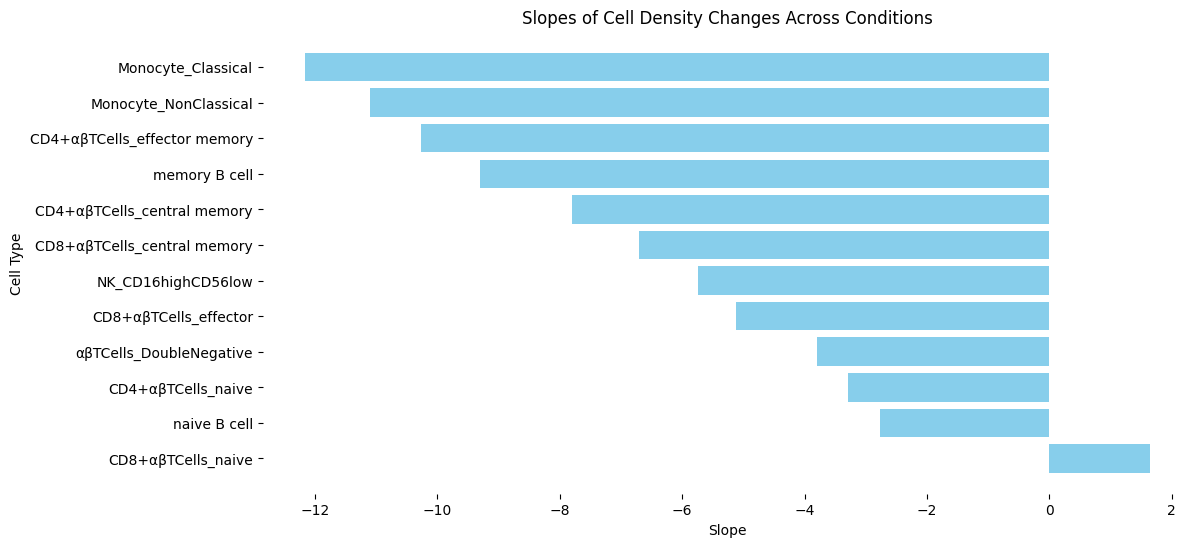

In [60]:
# horizontal bar plot
pivot_df_sorted = pivot_df.sort_values('Slope Rank')
plt.figure(figsize=(12, 6))
plt.barh(pivot_df['ReDefined_CellType'], pivot_df['Slope'], color='skyblue')
plt.title('Slopes of Cell Density Changes Across Conditions')
plt.xlabel('Slope')
plt.ylabel('Cell Type')
plt.show()